# Ablation studies

In this notebook we give the scripts for various ablation studies resented in out paper:
- **Weights**<br>
    Verifying the role of the pair of constant shared weights used for `epsilon` computation.<br>
- **Batch size**<br>
    Investigating the effect of the batch size.<br>
- **Synthetic data**<br>
    Changing the input data to verify dependency of the method on the data.
- **Initializations**<br>
    Changing initialization scheme.

## Weights ablations

In this ablation study we verify how much does the performance of epsilon metric change depending on the chosen weights.

In [1]:
import os
import json
import time
import itertools

import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from scipy import stats
from tqdm import trange
from dotmap import DotMap
from statistics import mean
import matplotlib.pyplot as plt
from prettytable import PrettyTable

import torch

import nasspace
from datasets import data
from epsilon_utils import prepare_seed

2022-10-05 14:27:27.468245: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-10.1/lib64:/usr/local/cuda-10.1/extras/CUPTI/lib64:/usr/local/cuda-10.1/lib64:/usr/local/cuda-10.1/extras/CUPTI/lib64
2022-10-05 14:27:27.468367: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-10.1/lib64:/usr/local/cuda-10.1/extras/CUPTI/lib64:/usr/local/cuda-10.1/lib64:/usr/local/cuda-10.1/extras/CUPTI/lib64
2022-10-05 14:27:27.468380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above

In [2]:
# Select the dataset. Choose among: 'cifar10', 'cifar100', 'ImageNet16-120'
dataset = 'cifar10'

if dataset=='ImageNet16-120':
    data_loc = './datasets/ImageNet16'
else:
    data_loc = './datasets/cifardata'

In [ ]:
save_loc = './results'
batch_size = 256
repeat = 1
GPU = '1'
augtype = 'none'
trainval = False

In [3]:
# Arguments required for NAS-Bench-201 search space initialisation
args = DotMap()
args.nasspace = 'nasbench201'
args.dataset = dataset
args.api_loc = './api/NAS-Bench-201-v1_1-096897.pth'

savedataset = dataset
dataset = 'fake' if 'fake' in savedataset else savedataset
savedataset = savedataset.replace('fake', '')
if savedataset == 'cifar10':
    savedataset = savedataset + '-valid'

In [ ]:
# Load the search space (it takes some time)
searchspace = nasspace.get_search_space(args)

In [4]:
if 'valid' in savedataset:
    savedataset = savedataset.replace('-valid', '')

if dataset == 'cifar10':
    acc_type = 'ori-test'
    val_acc_type = 'x-valid'
else:
    acc_type = 'x-test'
    val_acc_type = 'x-valid'

In [ ]:
# Define the device
os.environ['CUDA_VISIBLE_DEVICES'] = GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Randomly select n_samples architectures
prepare_seed(21)

In [5]:
# Load the data 
train_loader = data.get_data(dataset, data_loc, trainval, batch_size, augtype, repeat, args)
os.makedirs(args.save_loc, exist_ok=True)

# Pick up a batch
data_iterator = iter(train_loader)
x, _= next(data_iterator)
x = x.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
weight_range = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
add_header = True
for weight_comb in itertools.product(weight_range, weight_range):
    weight_l = weight_comb[0]
    weight_h = weight_comb[1]
    
    if weight_h>weight_l:
        save_dir = './release_results/ablation/weights/{}/weights_{}_{}/'.format(dataset.upper(), weight_l, weight_h)
        os.makedirs(save_dir, exist_ok=True)
        
        if os.path.exists(save_dir+'Data'):
            # Load precomputed results
            data_file = open(save_dir+'Data','rb')
            input_data = pkl.load(data_file)
            score = input_data["score"]
            accs = input_data["accs"]
            nparams = input_data["nparams"]
        else:
            save_dic = epsilon_main(data=x,
                                    space_name=args.nasspace,
                                    searchspace=searchspace, 
                                    n_archs=5000,
                                    weights=weights,
                                    device=device,
                                    args=args)
            pkl.dump(save_dic, open(save_dir + "Data", "wb"))
            
        if add_header:
            # Create output table
            headers = ["Weights", "Archs", "Spearman (global)", "Spearman (top-10%)", "Kendall (global)", "Kendall (top-10%)", "Top-10%/top-10%", "Top-64/top-5%"]
            table = PrettyTable(headers)
            add_header = False
        stats, remain = compute_stats(score, accs)
        stats_print = ["[{}, {}]".format(weight_l, weight_h), remain] + stats     
        table.add_row(stats_print)

In [7]:
import pandas as pd
pd.DataFrame(table.rows)

,0,1,2,3,4,5,6,7
0,"[1e-08, 1e-07]",2957,0.27,-0.46,0.20,-0.37,0.00,3.00
1,"[1e-08, 1e-06]",2957,0.42,-0.41,0.28,-0.30,4.39,1.00
2,"[1e-08, 1e-05]",2957,0.43,-0.19,0.31,-0.13,9.12,2.00
3,"[1e-08, 0.0001]",2957,0.47,-0.01,0.32,0.00,9.12,2.00
4,"[1e-08, 0.001]",2957,0.62,0.06,0.43,0.05,18.92,3.00
5,"[1e-08, 0.01]",2957,0.83,0.69,0.64,0.49,68.40,56.00
6,"[1e-08, 0.1]",2957,0.84,0.64,0.65,0.46,68.03,56.00
7,"[1e-08, 1]",2957,0.87,0.59,0.70,0.43,65.88,45.00
8,"[1e-08, 10]",2957,0.87,0.58,0.70,0.43,66.78,46.00
9,"[1e-07, 1e-06]",2957,0.33,-0.20,0.22,-0.13,4.76,1.00


## Batch size

We test the effect of the batch size used during `epsilon` metric computation.

In [7]:
batch_size_range = [8, 16, 32, 64, 128, 256, 512, 1024]

batch_all_spearman_all = []
batch_top10_spearman_all = []
batch_all_kendall_all = []
batch_top10_kendall_all = []
batch_top10top10_all = []
batch_top64top5_all = []

for batch_size in batch_size_range:
    batch_all_spearman = []
    batch_top10_spearman = []
    batch_all_kendall = []
    batch_top10_kendall = []
    batch_top10top10 = []
    batch_top64top5 = []
    
    for it in range(10):
        # Load the data batch
        if it==0:
            train_loader = data.get_data(dataset, data_loc, trainval, batch_size, augtype, repeat, args)
        data_iterator = iter(train_loader)
        x, _= next(data_iterator)
        x = x.to(device)

        save_dir = './release_results/ablation/batch_size/{}/bs_{}/'.format(dataset.upper(), batch_size)
        os.makedirs(save_dir, exist_ok=True)

        if os.path.exists(save_dir+'Data_' + str(it)):
            # Load precomputed results
            data_file = open(save_dir + 'Data_' + str(it),'rb')
            input_data = pkl.load(data_file)
            score = input_data["score"]
            accs = input_data["accs"]
            nparams = input_data["nparams"]
        else:
            save_dic = epsilon_main(data=x,
                                    space_name=args.nasspace,
                                    searchspace=searchspace, 
                                    n_archs=5000,
                                    weights=weights,
                                    device=device,
                                    args=args)
            pkl.dump(save_dic, open(save_dir + "Data_" + str(it), "wb"))

        stats, remain = compute_stats(score, accs, raw=True)
        batch_all_spearman.append(stats[0])
        batch_top10_spearman.append(stats[1])
        batch_all_kendall.append(stats[2])
        batch_top10_kendall.append(stats[3])
        batch_top10top10.append(stats[4])
        batch_top64top5.append(stats[5])

    batch_all_spearman_all.append(batch_all_spearman)
    batch_top10_spearman_all.append(batch_top10_spearman)
    batch_all_kendall_all.append(batch_all_kendall)
    batch_top10_kendall_all.append(batch_top10_kendall)
    batch_top10top10_all.append(batch_top10top10)
    batch_top64top5_all.append(batch_top64top5)

Files already downloaded and verified
Files already downloaded and verified


  0%|                                                | 0/15625 [00:00<?, ?it/s]


NameError: name 'space' is not defined

/home/gracheva/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


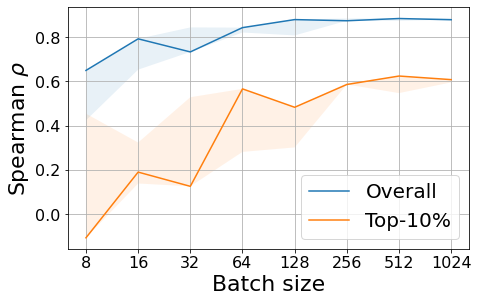

In [29]:
filename = save_dir+"BatchSize_Spearman_201_CIFAR10.pdf"
plot_experiment([(batch_all_spearman_all,'Overall'), (batch_top10_spearman_all,'Top-10%')], 'rho', filename)

/home/gracheva/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


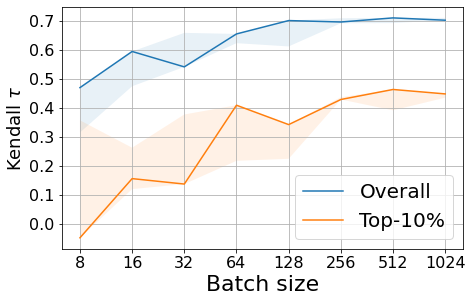

In [30]:
save_dir = './release_results/NAS-Bench-201/CIFAR10/Ablation/Batch Size/'
filename = save_dir+"BatchSize_Kendall_201_CIFAR10.pdf"
plot_experiment([(batch_all_kendall_all,'Overall'), (batch_top10_kendall_all,'Top-10%')], 'tau', filename)

## Synthetic data

In [9]:
# Grey scale
def grey_scale(bs):
    x = np.zeros((bs, 3, 32, 32))
    for i in range(args.batch_size):
        x[i,:,:,:]=1/args.batch_size*i
    x = torch.from_numpy(x)
    return x.to(device).float()

# Random normal
def random_normal(bs):
    x = np.random.normal(0, 1, size=(bs, 3, 32, 32))
    x = torch.from_numpy(x)
    return x.to(device).float()

# Ramdom uniform
def random_uniform_pos(bs):
    x = np.random.uniform(0, 1, size=(bs, 3, 32, 32))
    x = torch.from_numpy(x)
    return x.to(device).float()

# Ramdom uniform
def random_uniform(bs):
    x = np.random.uniform(-1, 1, size=(bs, 3, 32, 32))
    x = torch.from_numpy(x)
    return x.to(device).float()

def real_batch(args):
    # Load the data 
    train_loader = data.get_data(args.dataset, args.data_loc, args.trainval, args.batch_size, args.augtype, args.repeat, args)
    os.makedirs(args.save_loc, exist_ok=True)
    # Pick up a batch
    data_iterator = iter(train_loader)
    x, _= next(data_iterator)
    return x.to(device)

Files already downloaded and verified
Files already downloaded and verified


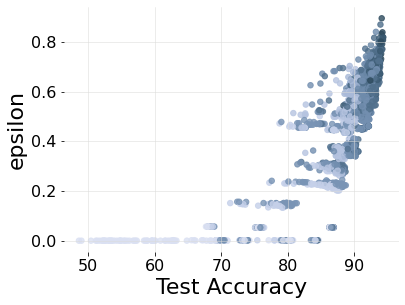

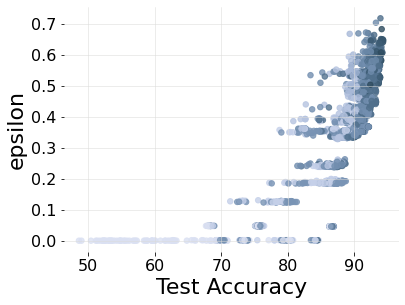

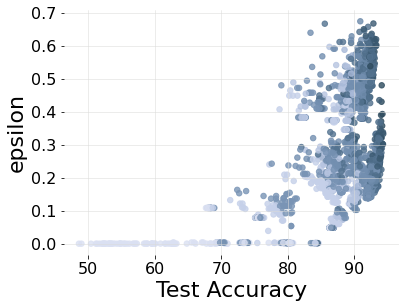

  0%|                                          | 9/5000 [00:00<08:18, 10.02it/s]/home/gracheva/Work/NAS/NAS-Bench-101/epsilon_utils.py:193: RuntimeWarning: invalid value encountered in true_divide
  pred_norm = (pred - pred_min)/(pred_max - pred_min)
/home/gracheva/Work/NAS/NAS-Bench-101/epsilon_utils.py:199: RuntimeWarning: Mean of empty slice
  mae = np.nanmean(np.abs(preds[0,:]-preds[1,:]))
/home/gracheva/Work/NAS/NAS-Bench-101/epsilon_utils.py:200: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(preds)
100%|███████████████████████████████████████| 5000/5000 [09:02<00:00,  9.22it/s]


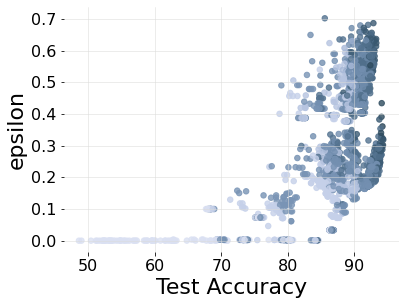

  0%|                                         | 10/5000 [00:02<10:34,  7.86it/s]/home/gracheva/Work/NAS/NAS-Bench-101/epsilon_utils.py:193: RuntimeWarning: invalid value encountered in true_divide
  pred_norm = (pred - pred_min)/(pred_max - pred_min)
/home/gracheva/Work/NAS/NAS-Bench-101/epsilon_utils.py:199: RuntimeWarning: Mean of empty slice
  mae = np.nanmean(np.abs(preds[0,:]-preds[1,:]))
/home/gracheva/Work/NAS/NAS-Bench-101/epsilon_utils.py:200: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(preds)
100%|███████████████████████████████████████| 5000/5000 [09:15<00:00,  9.01it/s]


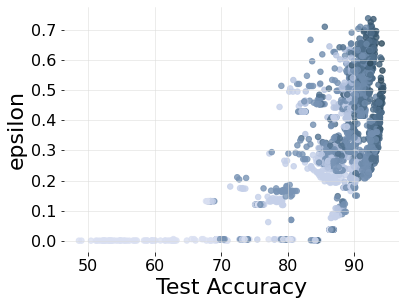

In [11]:
prepare_seed(21)
weights = [1e-7, 1]

input_names=['real_batch',
             'grey_scale',
             'random_normal',
             'random_uniform',
             'random_uniform_pos']
it=0
for input_name in input_names:
    save_dir = './release_results/ablation/synthetic_input/{}/{}/'.format(dataset.upper(), input_name)
    os.makedirs(save_dir, exist_ok=True)
    
    if input_name=='real_batch':
        x = real_batch(args)
    elif input_name=='grey_scale':
        x = grey_scale(args.batch_size)
    elif input_name=='random_normal':
        x = random_normal(args.batch_size)
    elif input_name=='random_uniform':
        x = random_uniform(args.batch_size)
    elif input_name=='random_uniform_pos':
        x = random_uniform_pos(args.batch_size)

    if os.path.exists(save_dir+'Data'):
        # Load precomputed results
        data_file = open(save_dir+'Data','rb')
        input_data = pkl.load(data_file)
        score = input_data["score"]
        accs = input_data["accs"]
        nparams = input_data["nparams"]
    else:
        save_dic = epsilon_main(data=x,
                                space_name=args.nasspace,
                                searchspace=searchspace, 
                                n_archs=5000,
                                weights=weights,
                                device=device,
                                args=args)
        pkl.dump(save_dic, open(save_dir + "Data", "wb"))
        score = save_dic['score']
        accs = save_dic['accs']

    if it==0:
        # Make the table
        headers = ["Input", "Archs", "Spearman (global)", "Spearman (top-10%)", "Kendall (global)", "Kendall (top-10%)", "Top-10%/top-10%", "Top-64/top-5%"]
        table = PrettyTable(headers)
    
    stats, remain = compute_stats(score, accs)
    stats_print = [input_name, remain] + stats  
    table.add_row(stats_print)
    it+=1

    plot_results(score=score,
                 accs=accs,
                 nparams=nparams,
                 top10=False,
                 log_scale=False,
                 save_dir=save_dir,
                 save_name="Epsilon_{}".format(input_name))

In [12]:
table

Input,Archs,Spearman (global),Spearman (top-10%),Kendall (global),Kendall (top-10%),Top-10%/top-10%,Top-64/top-5%
real_batch,2957,0.87,0.59,0.70,0.43,65.88,45.00
grey_scale,2957,0.87,0.44,0.68,0.31,59.46,34.00
random_normal,2957,0.54,0.15,0.38,0.14,14.97,3.00
random_uniform,2957,0.56,0.17,0.40,0.16,14.19,3.00
random_uniform_pos,2957,0.61,0.17,0.43,0.16,16.22,4.00


### Initialisation algorithm

In [ ]:
# Constant shared weights
# Kaiming uniform 
# Kaiming normal